# 5.1) 중고나라 핸드폰 거래가격 예측하기

### 바로가기

- [<Step1. 탐색적 분석> : 중고나라 데이터 분석](#<Step1.-탐색적-분석>-:-중고나라-데이터-분석)
    - [중고나라 데이터셋 살펴보기]
    - [개별 피처 탐색하기]
    - [Random forest regressor를 이용한 가격 예측]
- [<Step2. 피처 엔지니어링> : 예측 모델 개선](#<Step2.-피처-엔지니어링>-:-예측-모델-개선)
    - [기존 feature의 가공]
- [<Step3. 예측> : 중고폰 거래가 예측](#<Step3.-예측>-:-중고폰-거래가-예측)
    - [Random forest regressor 재학습]
    - [최적의 모델 파라미터 찾기]
- [<Step4. 프로토타입> : 얼마고(Almhago?)](#<Step4.-프로토타입>-:-얼마고(Almhago?))
    - [재사용을 위한 파일 저장]
    - [가격 예측 프로그램 만들기]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# <Step1. 탐색적 분석> : 중고나라 데이터 분석

### [중고나라 데이터셋 살펴보기]

In [3]:
df = pd.read_csv("중고나라 2021-11-08나이키 에어맥스 97 매물_가격수정.csv")
# df=df.drop(columns=['price_index'],axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1493 entries, 0 to 1492
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   create_date    1493 non-null   object
 1   text           1493 non-null   object
 2   model          1493 non-null   object
 3   price          1493 non-null   int64 
 4   factory_price  1493 non-null   int64 
 5   maker          1493 non-null   object
dtypes: int64(2), object(4)
memory usage: 70.1+ KB
None


,create_date,text,model,price,factory_price,maker
0,2021.11.08. 17:24,나이키 에어맥스97 OG 실버불렛 / 나코탭 새제품 / 275,나이키 에어맥스 97,350000,199000,Nike
1,2021.11.08. 16:45,나이키 에어맥스97 페르시안 바이올렛 미개봉 275 팝니다,나이키 에어맥스 97,125000,199000,Nike
2,2021.11.08. 16:18,나이키에어맥스97 트리플화이트 235,나이키 에어맥스 97,130000,199000,Nike
3,2021.11.08. 16:15,나이키 에어맥스 97 250사이즈,나이키 에어맥스 97,2000,199000,Nike
4,2021.11.08. 16:14,나이키 에어맥스97 핑크크림 250,나이키 에어맥스 97,135000,199000,Nike


-----

### [개별 피처 탐색하기]

##### date 피처 탐색

In [4]:
# create_date로부터 ‘월’을 의미하는 month 정보를 피처로 추출합니다.
df['month'] = df['create_date'].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력합니다.
df['month'].value_counts()

2021.11    599
2021.10    417
2021.07     87
2021.09     67
2021.08     57
2020.11     44
2021.04     40
2021.06     34
2020.12     30
2021.05     29
2021.03     28
2021.02     18
2021.01     18
2020.09     10
2020.08      7
2020.10      5
2020.07      3
Name: month, dtype: int64

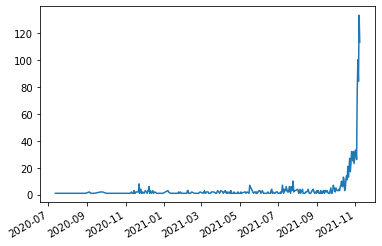

In [5]:
# 일별 거래 횟수를 계산하여 그래프로 출력합니다.
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

-----

##### 가격 피처 탐색

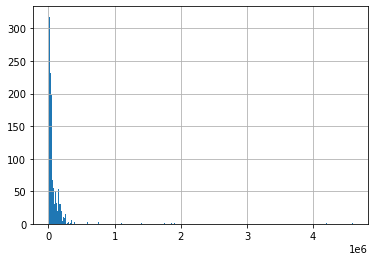

In [6]:
# 가격의 분포를 그래프로 탐색합니다.
df['price'].hist(bins="auto")

In [7]:
# 핸드폰 기종(phone_model)별 가격의 평균과 표준편차를 계산합니다.
df_price_model_mean = df.groupby('model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('model')['price'].transform(lambda x: np.std(x))

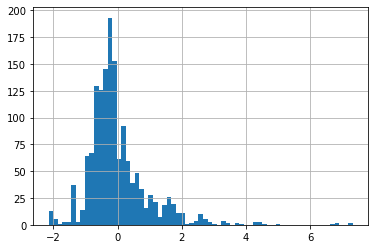

In [8]:
# 이를 바탕으로 모든 데이터의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

-----

##### 출고가 피처 탐색

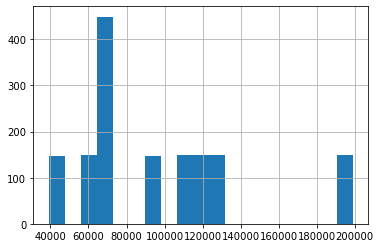

In [9]:
# factory_price 피처의 분포를 탐색합니다.
df['factory_price'].hist(bins="auto")

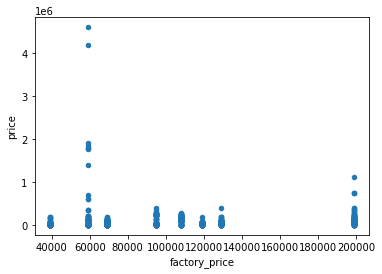

In [10]:
# factory_price와 price 피처를 scatter plot으로 출력하여, 상관관계를 살펴봅니다.
df.plot.scatter(x='factory_price', y='price')

-----

##### 핸드폰 모델 피처 탐색

count     10.000000
mean     149.300000
std        0.823273
min      148.000000
25%      149.000000
50%      149.500000
75%      150.000000
max      150.000000
Name: model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1e9cba6a910>,
 'caps': [<matplotlib.lines.Line2D at 0x1e9cbb63cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e9cbbb97f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e9cbc0af70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e9cbc5b4c0>],
 'means': []}

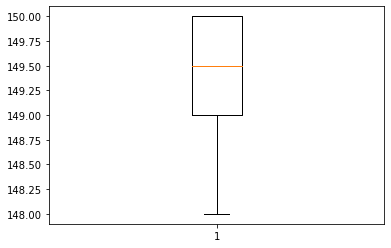

In [11]:
# 기종별 총 거래 데이터 개수를 집계합니다.
model_counts = df['model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봅니다.
plt.boxplot(model_counts)

-----

##### 메이커 피처 탐색

Nike           150
New_Balance    150
VANS           150
Converse       150
Nuovo          150
Adidas         149
Puma           149
ReeBok         149
Birkenstock    148
hawkins        148
Name: maker, dtype: int64


{'whiskers': [<matplotlib.lines.Line2D at 0x1e9cb63b940>,
 'caps': [<matplotlib.lines.Line2D at 0x1e9cb6486d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e9cb63bca0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e9cb6488b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e9cb6489a0>],
 'means': []}

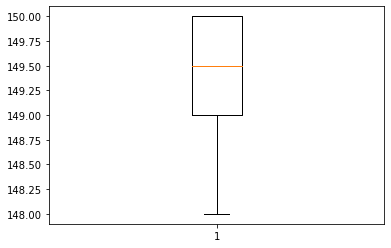

In [12]:
maker_counts = df['maker'].value_counts()
print(maker_counts)
plt.boxplot(maker_counts)

-----

### [Random forest regressor를 이용한 가격 예측]

In [13]:
df.head()

,create_date,text,model,price,factory_price,maker,month
0,2021.11.08. 17:24,나이키 에어맥스97 OG 실버불렛 / 나코탭 새제품 / 275,나이키 에어맥스 97,350000,199000,Nike,2021.11
1,2021.11.08. 16:45,나이키 에어맥스97 페르시안 바이올렛 미개봉 275 팝니다,나이키 에어맥스 97,125000,199000,Nike,2021.11
2,2021.11.08. 16:18,나이키에어맥스97 트리플화이트 235,나이키 에어맥스 97,130000,199000,Nike,2021.11
3,2021.11.08. 16:15,나이키 에어맥스 97 250사이즈,나이키 에어맥스 97,2000,199000,Nike,2021.11
4,2021.11.08. 16:14,나이키 에어맥스97 핑크크림 250,나이키 에어맥스 97,135000,199000,Nike,2021.11


-----

##### Random forest 모델 학습

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 데이터를 학습/테스트용 데이터로 분리합니다.
df = df[['price', 'model', 'factory_price', 'maker', 'month']]
df = pd.get_dummies(df, columns=['model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습합니다.
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델을 평가합니다.
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 43757701642.918, test: 21258808998.045
R^2 train: 0.175, test: -0.083


##### 피처 중요도 분석

[('month_2021.07', 0.37517480314287),
 ('maker_Nuovo', 0.1049066269152065),
 ('model_누오보 바베트', 0.09607373913578937),
 ('month_2021.04', 0.08956760869721486),
 ('factory_price', 0.07564079293866695),
 ('month_2021.10', 0.04918310755158328),
 ('maker_New_Balance', 0.03972979301782963),
 ('model_뉴발란스 문빔', 0.03393728597928084),
 ('model_나이키 에어맥스 97', 0.02835862831063832),
 ('month_2021.11', 0.027737426246483416)]

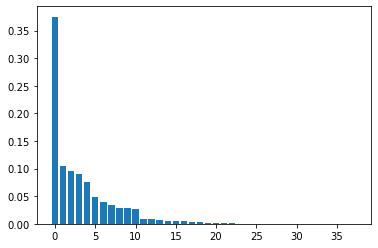

In [15]:
# 학습한 모델의 피처 중요도를 그래프로 살펴봅니다.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [16]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력합니다.
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]: 
        print(sorted_feature)

('month_2021.07', 0.37517480314287)
('month_2021.04', 0.08956760869721486)
('month_2021.10', 0.04918310755158328)
('month_2021.11', 0.027737426246483416)
('month_2021.09', 0.007010829778173925)
('month_2021.08', 0.005525290751128577)
('month_2021.06', 0.0009915924067309915)
('month_2021.05', 0.0005838188217949654)
('month_2021.03', 0.0004109411278042117)
('month_2020.07', 0.00016902153163212493)
('month_2020.11', 0.00016031380997138747)
('month_2020.12', 0.00013152095463508614)
('month_2021.02', 0.00012597499308146352)
('month_2021.01', 9.050883262981025e-05)
('month_2020.09', 8.161551404356532e-05)
('month_2020.08', 3.733117004989938e-05)
('month_2020.10', 3.051500903406417e-05)


-----

##### 예측 결과 scatter plot

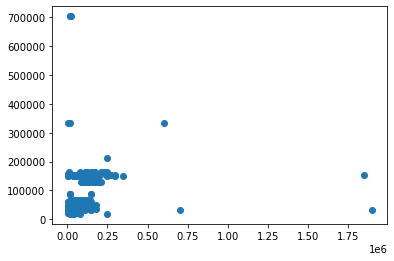

In [17]:
plt.scatter(y_test.values, y_test_pred)

-----

# <Step2. 피처 엔지니어링> : 예측 모델 개선

### [기존 feature의 가공]

In [18]:
# 데이터를 다시 불러옵니다.
df = pd.read_csv("중고나라 2021-11-08나이키 에어맥스 97 매물_가격수정.csv")

##### create_date로 시간점수 생성하기

In [19]:
from datetime import datetime
import time

# create_date 피처를 수치적으로 계산하기 위해, unixtime으로 변환하는 함수를 정의합니다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y.%m.%d').timetuple())
    return timestamp

# create_date 피처를 ‘현재와 얼마나 가까운 데이터인 지’ 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환합니다.
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))
print(df['create_unixtime'][:10])

0    1.636297e+09
1    1.636297e+09
2    1.636297e+09
3    1.636297e+09
4    1.636297e+09
5    1.636297e+09
6    1.636297e+09
7    1.636297e+09
8    1.636297e+09
9    1.636297e+09
Name: create_unixtime, dtype: float64


In [20]:
# 변환된 unixtime에 min-max 스케일링을 적용합니다.
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                          (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2021.11.08. 17:24,1.636297e+09,1.0
1,2021.11.08. 16:45,1.636297e+09,1.0
2,2021.11.08. 16:18,1.636297e+09,1.0
3,2021.11.08. 16:15,1.636297e+09,1.0
4,2021.11.08. 16:14,1.636297e+09,1.0


-----

##### phone_model 피처 분리

In [21]:
# # phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출합니다.
# df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
# df[[ 'phone_model_detail']].head()

In [22]:
# # phone_model 피처의 기종별 거래 데이터 개수를 집계합니다.
# model_counts = df['phone_model'].value_counts()

# # phone_model_detail 피처의 기종별 거래 데이터 개수를 집계합니다.
# model_detail_counts = df['phone_model_detail'].value_counts()
# data = [model_counts, model_detail_counts]

# # 두 피처간의 기종별 거래 데이터 개수를 비교합니다.
# mpl_fig = plt.figure()
# ax = mpl_fig.add_subplot(111)
# ax.boxplot(data)

-----

##### phone_model 관련 딕셔너리 생성

In [23]:
# 기종명 으로 출고가를 찾기 위한 딕셔너리를 생성합니다.
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['model'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{'나이키 에어맥스 97': 199000, '누오보 바베트': 59000 ...


-----

# <Step3. 예측> : 중고폰 거래가 예측

### [Random forest regressor 재학습]

MSE train: 19058968452.464, test: 23746326917.627
R^2 train: 0.641, test: -0.210


[('create_time_score', 0.8946483337069404),
 ('maker_Nuovo', 0.024625701577673357),
 ('model_누오보 바베트', 0.021981065374564207),
 ('factory_price', 0.011876799688068712),
 ('maker_New_Balance', 0.009766626637369028),
 ('model_뉴발란스 문빔', 0.009378671005047658),
 ('model_나이키 에어맥스 97', 0.007365112092407389),
 ('maker_Nike', 0.00712022923603286),
 ('model_버켄스탁 아리조나', 0.004613316524500888),
 ('maker_Birkenstock', 0.0044349482216798995)]

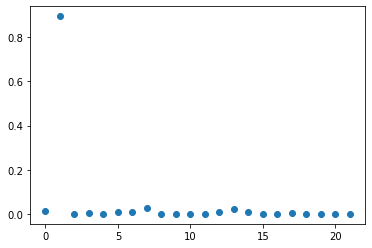

In [24]:
# 랜덤 포레스트 모델 학습을 위한 데이터를 준비합니다.
df = df[['price', 'factory_price', 'maker', 'create_time_score', 'model']]
df = pd.get_dummies(df, columns=['maker', 'model',])

# 학습/테스트 데이터를 분리합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습하고 평가합니다.
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot을 출력합니다.
importances = forest.feature_importances_
plt.plot(importances, "o")

# 피처 중요도를 print로 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

------

##### feature-index 관련 딕셔너리 생성

In [25]:
# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성합니다.
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'create_time_score' ...


-----

##### 예측 결과 scatter plot

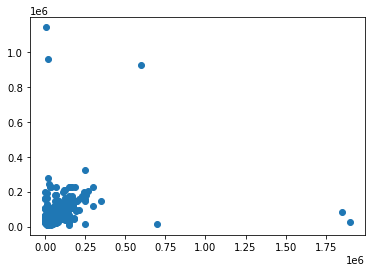

In [26]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴봅니다.
plt.scatter(y_test.values, y_test_pred)

-----

### [최적의 모델 파라미터 찾기]

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정합니다.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의합니다.
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# RandomizedSearchCV 모델을 학습합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

-----

##### 최적 파라미터 출력

In [28]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력합니다.
optimal_forest.best_params_

{'n_estimators': 200,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

-----

##### 최적 모델 학습 결과

MSE train: 21044529677.088, test: 7808242291.011
R^2 train: 0.603, test: 0.602


[('create_time_score', 0.8827436315626109),
 ('maker_Nuovo', 0.027369677880441895),
 ('model_누오보 바베트', 0.019467536368423244),
 ('factory_price', 0.015193435719307497),
 ('maker_Nike', 0.008218770543256778),
 ('maker_New_Balance', 0.00801512445248736),
 ('model_뉴발란스 문빔', 0.007693985181084535),
 ('model_버켄스탁 아리조나', 0.006706505292020895),
 ('model_나이키 에어맥스 97', 0.006186124137585754),
 ('model_리복 로얄 하이페리움 2', 0.002398296062336011)]

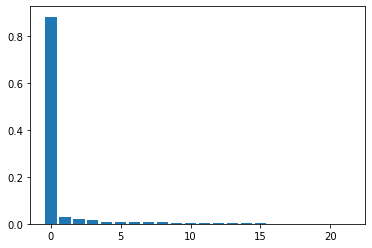

In [29]:
# 최적의 파라미터를 적용한 모델로 중고폰의 가격을 예측하고 평가합니다.
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 가격 예측 모델의 피처 중요도 plot을 출력합니다.
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 가격 예측 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

-----

##### 예측 결과 scatter plot

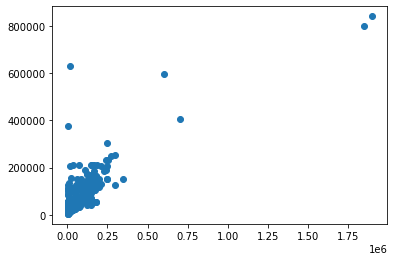

In [30]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴봅니다.
plt.scatter(y_test.values, y_test_pred)

-----

# <Step4. 프로토타입> : 얼마고(Almhago?)

### [재사용을 위한 파일 저장]

In [34]:
import joblib
import pickle

# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장합니다.
with open('./pkl/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('./pkl/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
# with open('./pkl/common_words.pickle', 'wb') as f:
#     pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
# with open('./pkl/init_vectorizer_vocabulary.pickle', 'wb') as f:
#     pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
# with open('../pkl/tfidf_vectorizer.pickle', 'wb') as f:
#     pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
# with open('../pkl/svm_classifier.pickle', 'wb') as f:
#     pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, './pkl/rf_regressor.pickle', compress = 1)

['./pkl/rf_regressor.pickle']

-----

### [가격 예측 프로그램 만들기]

##### 예측에 필요한 파일 로드

In [36]:
import pickle

with open('./pkl/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('./pkl/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
# with open('../data/used_mobile_pickles/common_words.pickle', 'rb') as f:
#     common_words = pickle.load(f)

# with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
#     init_vectorizer_vocabulary = pickle.load(f)
    
# with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
#     tfidf_vectorizer = pickle.load(f)
    
# with open('../data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
#     svm_classifier = pickle.load(f)

rf_regressor = joblib.load('./pkl/rf_regressor.pickle')

-----

##### 프로그램(클래스) 만들기

In [51]:
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, price_regressor, status_text):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._price_regressor = price_regressor
        self._status_text= status_text
        
#     def _get_common_pos(self, x):
#         tagger = Okt()
#         poses = tagger.pos(x)
#         return [pos[0] for pos in poses if pos[0] in self._common_words]
    
#     def _text_cleaning(self, text):
#         text = ''.join(c for c in text if c.isalnum() or c in '+, ')
#         text = ''.join([i for i in text if not i.isdigit()])
#         return text
        
#     def _init_index_vectorizer(self):
#         word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
#         word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
#         return word_index_vectorizer
    
    def _get_ftr_price(self, model_name):
        return self._model_to_factory_price_dict[(model_name)]
    
#     def _get_prd_status(self, text):
#         X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
#         X = self._tfidf_vectorizer.transform(X)
#         return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        if prd_status == "상":
            result_price1= int(price[0])*0.9
            result_price2= int(price[0])*1.1
        elif prd_status == "중":
            result_price1= int(price[0])*0.8
            result_price2= int(price[0])
        else:
            result_price1= int(price[0])*0.7
            result_price2= int(price[0])*0.9
        print("선택하신", model, "상품은", prd_status, "급의 상태입니다. 중고가 예상 가격은", str(round(result_price1)), " ~ ", str(round(result_price2)), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(22)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['model'])
#         feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["model", input_dict['model']])]] = 1
#         feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['model'], 
                            predicted_price, 
                            self._status_text)

-----

##### 프로그램 테스트

In [52]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 두 개(price_index, create_time_score)의 피처를 정의합니다.
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글을 입력합니다.
program_test_dict = {"maker": "Nike",
                     "model": "나이키 에어맥스 97",
                     "text": "나이키 에어맥스 97 245mm 팔아요~ 직접거래 \
                         10만원에 팔아요 \
                         기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며 택배거래도 가능해요",
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트를 생성합니다.
status=input("상태를 입력해주세요(상, 중, 하): ")
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, rf_regressor, status)

# 입력한 데이터로 판매 가격을 예측합니다.
almhago.predict(program_test_dict)

상태를 입력해주세요(상, 중, 하): 상
선택하신 나이키 에어맥스 97 상품은 상 급의 상태입니다. 중고가 예상 가격은 93424  ~  114186 원 입니다.
